Dorian Gailhard - Computational Statistics HW4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import pandas as pd

In [2]:
#Exercise 1)
#A) 1)
a = 10
sigma_1 = 3
sigma_2 = 3

In [3]:
def HM_sampling(density,maxIter,z0,sigma2):
    z = z0
    
    for k in range(1,maxIter):
        #Proposal
        z_star = sp.multivariate_normal.rvs(mean=z,cov=sigma2)
        
        if (np.random.uniform() < min(1,density(z_star)/density(z))):
            z = z_star
    return z

In [4]:
def density(x,y):
    return np.exp(-x**2/a**2 - y**2 - ((x**2/a**2-y**2)**2)/4)

In [5]:
def gibbs_sampling(n_iter,x0):
    chain = np.zeros(n_iter*2+1)
    chain[0] = x0
    
    for i in range(0,n_iter):
        density_P2 = lambda y : density(chain[2*i],y)
        chain[2*i+1] = HM_sampling(density_P2,50,chain[2*i-1],sigma_2)
        
        density_P1 = lambda x : density(x,chain[2*i+1])
        chain[2*i+2] = HM_sampling(density_P1,50,chain[2*i],sigma_1)
    
    return chain

In [6]:
#2)
chain = gibbs_sampling(1000,0)

A lot of performance is lost because the proposal is always the same despite the sampled density changing, so the ratio decreases and a lot of proposals are for nothing.

3) The performance could be improved by having a better acceptance rate ie having a better proposal so that more proposals are accepted such that there are less "useless" computation - a refused proposal cost as much as an accepted one despite not making any progress in the random walk.

A second improvement would be to have a proposal for which the correlation between the initial conditions and the following steps vanishes quicker so that less steps are needed in the HM sampling.

In [7]:
#B)
def adaptive_gibbs_sampling(n_iter,x0):
    l = np.zeros(2)
    
    acceptance_count = np.zeros(2)
    
    def adaptive_HM(density,maxIter,z0,var):
        #var denotes if we are sampling the first or second variable
        z = z0
        cov=np.exp(l[var])
        
        for k in range(1,maxIter):
            #Proposal
            z_star = sp.multivariate_normal.rvs(mean=z,cov=cov)

            if (np.random.uniform() < min(1,density(z_star)/density(z))):
                z = z_star
                acceptance_count[var] += 1

        return z

    chain = np.zeros(n_iter*2+1)
    chain[0] = x0
    
    for j in range(n_iter):
        density_P2 = lambda y : density(chain[2*j],y)
        chain[2*j+1] = adaptive_HM(density_P2,50,chain[2*j-1],var=1)
        
        density_P1 = lambda x : density(x,chain[2*j+1])
        chain[2*j+2] = adaptive_HM(density_P1,50,chain[2*j],var=0)
        
        #We update the l
        acceptance_rate = acceptance_count/50
        acceptance_count = np.zeros(2) #reset
        
        delta = np.min([0.01,(j+1)**(-0.5)])
        l = l + np.where(acceptance_rate < 0.24,+delta,-delta)
    
    return chain

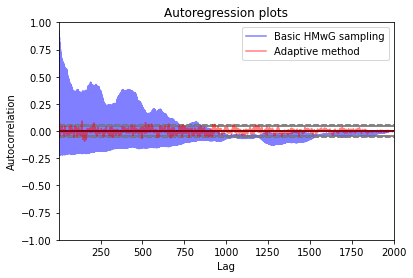

In [9]:
adaptive_chain = adaptive_gibbs_sampling(1000,0)

pd.plotting.autocorrelation_plot(adaptive_chain,label="Basic HMwG sampling", color='blue', alpha = 0.5)
pd.plotting.autocorrelation_plot(chain,label="Adaptive method", color='red', alpha = 0.5)
plt.title("Autoregression plots")
plt.legend()
plt.show()

The adaptive method produces far less correlated samples. The plots depict hulls and not lines because the samples are encoded sequentially - [X0, Y0, X1 ...] - and not grouped by index - [[X0, Y0], ...].

In [10]:
#2)
d = 2
B = 0.1

def density_complete(x):
    return np.exp(-x[0]**2/200 - 0.5*(x[1] + B*x[0]**2 - 100*B)**2 - 0.5*(np.sum(x[2:]**2)))

In [11]:
def gibbs_sampling(density,n_iter,x0):
    chain = np.zeros((n_iter+1,d))
    chain[0] = x0
    
    for i in range(1,n_iter+1):
        for j in range(d):
            new_density = lambda y : density(np.concatenate((chain[i,0:j],[y],chain[i-1,j+1:])))
            chain[i,j] = HM_sampling(new_density,50,chain[i-1,j],0.1)
    return chain

In [12]:
def adaptive_gibbs_sampling(density,n_iter,x0):
    l = np.zeros(d)
    
    acceptance_count = np.zeros(d)
    
    def adaptive_HM(density,maxIter,z0,var):
        #var denotes which variable we are sampling
        z = z0
        cov=np.exp(l[var])
        
        for k in range(1,maxIter):
            #Proposal
            z_star = sp.multivariate_normal.rvs(mean=z,cov=cov)

            if (np.random.uniform() < min(1,density(z_star)/density(z))):
                z = z_star
                acceptance_count[var] += 1

        return z

    chain = np.zeros((n_iter+1,d))
    chain[0] = x0
    
    for i in range(1,n_iter+1):
        for j in range(d):
            new_density = lambda y : density(np.concatenate((chain[i,0:j],[y],chain[i-1,j+1:])))
            chain[i,j] = adaptive_HM(new_density,50,chain[i-1,j],var=j)
        
        #We update the l
        acceptance_rate = acceptance_count/50
        acceptance_count = np.zeros(d) #reset
        
        delta = np.min([0.01,(j+1)**(-0.5)])
        l = l + np.where(acceptance_rate < 0.24,+delta,-delta)
    
    return chain

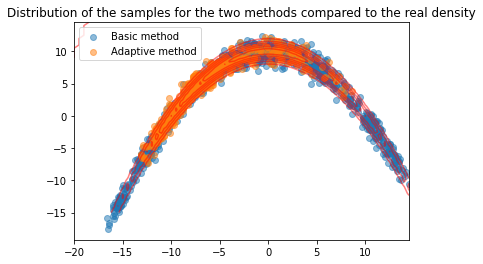

In [13]:
x0 = np.zeros(d)
x0[1] = 100*B

samples = np.zeros((2000,2))

chain = gibbs_sampling(density_complete,1000,x0)
adaptive_chain = adaptive_gibbs_sampling(density_complete,1000,x0)

x, y = np.mgrid[-20:15:.5, -15:15:.5]
data = np.dstack((x, y))

z = np.apply_along_axis(density_complete,2,data)
plt.contour(x, y, z, colors="red",alpha=0.5)

plt.scatter([s[0] for s in chain],[s[1] for s in chain],alpha=0.5,label="Basic method")
plt.scatter([s[0] for s in adaptive_chain],[s[1] for s in adaptive_chain],alpha=0.5,label="Adaptive method")
plt.legend()
plt.title("Distribution of the samples for the two methods compared to the real density")
plt.show()

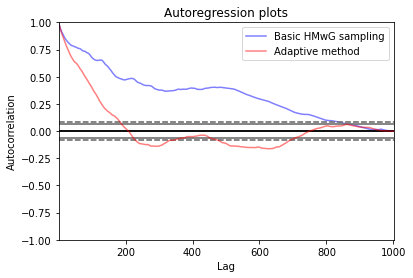

In [14]:
pd.plotting.autocorrelation_plot(adaptive_chain,label="Basic HMwG sampling", color='blue', alpha = 0.5)
pd.plotting.autocorrelation_plot(chain,label="Adaptive method", color='red', alpha = 0.5)
plt.title("Autoregression plots")
plt.legend()
plt.show()

In [10]:
#Exercise 2) A)
mus = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],[4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],[8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31],[5.54,6.86],[1.69,8.11]])
w = 0.05
sigma2 = 0.01

def density(x):
    return np.sum([w/(2*np.pi*sigma2)*np.exp(-1/(2*np.pi*sigma2)*(x-mu)@(x-mu)) for mu in mus])

In [44]:
def adaptive_HM(density,maxIter,z0):
    chain = np.zeros((maxIter,2))
    chain[0] = z0
    
    l = 0
    acceptance_count = 0
    
    z = z0
    cov=np.exp(l)

    for k in range(1,maxIter):
        #Updating the variance
        if k%50 == 0:
            acceptance_rate = acceptance_count/50
            acceptance_count = 0
            
            delta = np.min([0.01,(k//50)**(-0.5)])
            
            if acceptance_rate < 0.24:
                l += delta
            else:
                l -= delta
        
        #Proposal
        z_star = sp.multivariate_normal.rvs(mean=z,cov=cov)

        if (np.random.uniform() < min(1,density(z_star)/density(z))):
            z = z_star
            acceptance_count += 1
        
        chain[k] = z

    return chain

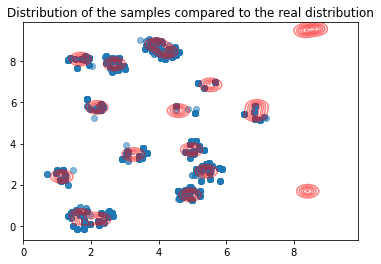

In [12]:
chain = adaptive_HM(density,2000,mus[0])

plt.scatter([s[0] for s in chain],[s[1] for s in chain],alpha=0.5)

x, y = np.mgrid[0:10:.1, 0:10:.1]
data = np.dstack((x, y))

z = np.apply_along_axis(density,2,data)
plt.contour(x, y, z, colors="red",alpha=0.5)
    
plt.title("Distribution of the samples compared to the real distribution")
plt.show()

There should be an equal amount of samples in each clusters, but here, despite a high number of samples, it is clearly not the case, some clusters have a huge amount of them while other, especially the isolated ones, are never visited. The sampling method fails in this example.

In [43]:
#B)
def parrallel_tempering(pi,n_iter,T,X0):
    K = T.shape[0]

    X = np.full((5,2),X0)
    Y = np.zeros((K,2))
    
    chain = np.zeros((n_iter+1,2))
    chain[0] = X0
    
    for n in range(1,n_iter+1):
        for i in range(K):
            density = lambda x: pi(x)**(1/T[i])
            Y[i] = HM_sampling(density,30,X[i],sigma2=np.eye(2)*(0.25)**2*T[i]) #1 stands for maxIter=1, we only do one step
            
        #Choosing i and j
        i = np.random.randint(low=1,high=K-1)
        
        if np.random.uniform() < 0.5:
            j = i-1
        else:
            j = i+1
        
        #Update and swap
        for k in range(K):
            if k != i and k != j:
                X[k] = Y[k]
            else:
                if k == i:
                    acceptance_ratio = min(1,pi(Y[j])**(1/T[i]) * pi(Y[i])**(1/T[j]) / (pi(Y[i])**(1/T[i]) * pi(Y[j])**(1/T[j])))
                    if np.random.uniform() < acceptance_ratio:
                        X[i],X[j] = Y[j],Y[i]
        
        chain[n] = X[K-1]
            
    return chain

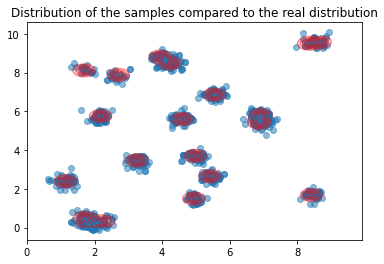

In [44]:
#2)
T = np.array([90,21.6,7.7,2.8,1.])

chain = parrallel_tempering(density,1000,T,mus[0])

plt.scatter([s[0] for s in chain],[s[1] for s in chain],alpha=0.5)

x, y = np.mgrid[0:10:.1, 0:10:.1]
data = np.dstack((x, y))

z = np.apply_along_axis(density,2,data)
plt.contour(x, y, z, colors="red",alpha=0.5)
    
plt.title("Distribution of the samples compared to the real distribution")
plt.show()

The sampling method visits each clusters in a much more even manner, even if some clusters are still more frequently visited than others. The sampling is much better.

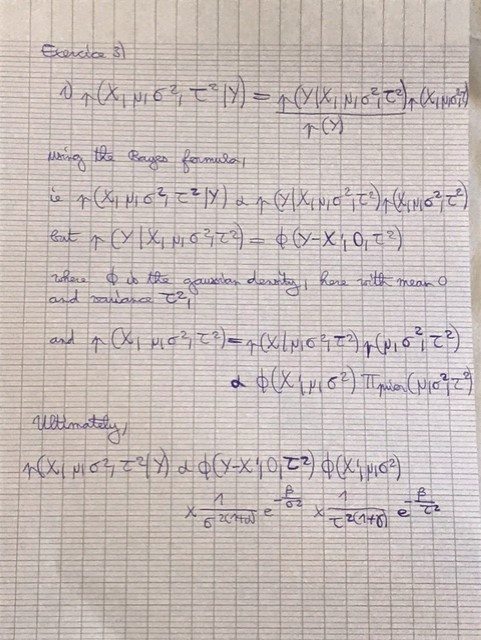

In [15]:
beta = 0.1
alpha = 0.1
gamma = 0.1

In [16]:
#2)
def adaptive_gibbs_sampling_posterior(n_iter,z0,Y):
    z = z0 #x = [X, mu, sigma2, tau2]
    
    n = z0.shape[0]-3
    m = Y.reshape(-1).shape[0]
    
    l = np.zeros(n+3)
    
    acceptance_count = np.zeros(n+3)
    
    def adaptive_HM(density,maxIter,zstart,var):
        #var denotes if we are sampling the first or second variable
        z = zstart
        cov=np.exp(l[var])
        
        for k in range(1,maxIter):
            #Proposal
            z_star = sp.multivariate_normal.rvs(mean=z,cov=cov)

            if (np.random.uniform() < min(1,density(z_star)/density(z))):
                z = z_star
                acceptance_count[var] += 1

        return z
    
    for j in range(n_iter):
        #For sigma2
        density = lambda t : 0 if t<=0 else sp.multivariate_normal.pdf(X,[z[-3]]*n,t*np.eye(n))*sp.gamma.pdf(t, alpha, scale=1/beta)
        z[-2] = adaptive_HM(density,50,z[-2],var=-2)
        
        #For tau2
        density = lambda t : 0 if t<=0 else sp.multivariate_normal.pdf((Y-X.reshape(-1,1)).reshape(-1),np.zeros(m),t*np.eye(m))*sp.gamma.pdf(t, gamma, scale=1/beta)
        z[-1] = adaptive_HM(density,50,z[-1],var=-1)
        
        #For mu
        density = lambda t : sp.multivariate_normal.pdf(X,[t]*n,z[-2]*np.eye(n))
        z[-3] = adaptive_HM(density,50,z[-3],var=-3)
        
        #For X
        for k in range(n):
            density = lambda t : sp.multivariate_normal.pdf((Y[k]-t.reshape(-1,1)).reshape(-1),np.zeros(m),z[-1]*np.eye(m))*sp.multivariate_normal.pdf(t,z[-3],z[-2])
            z[k] = adaptive_HM(density,50,z[k],var=k)
            
        #We update the l
        acceptance_rate = acceptance_count/50
        acceptance_count = np.zeros(4) #reset
        
        delta = np.min([0.01,(j+1)**(-0.5)])
        l = l + np.where(acceptance_rate < 0.24,+delta,-delta)
    
    return z

In [17]:
#3)
def adaptive_block_gibbs_sampling_posterior(n_iter,z0,Y):
    z = z0 #z = [X, mu, sigma2, tau2]
    
    n = z0.shape[0]-3
    m = Y.reshape(-1).shape[0]
    
    l = np.zeros(n+3)
    acceptance_count = np.zeros(n+3)
    
    def adaptive_HM(density,maxIter,zstart,var):
        #var denotes if we are sampling the first or second variable
        z = zstart
        cov=np.exp(l[var])
        
        for k in range(1,maxIter):
            #Proposal
            z_star = sp.multivariate_normal.rvs(mean=z,cov=cov)
            
            if (np.random.uniform() < min(1,density(z_star)/density(z))):
                z = z_star
                acceptance_count[var] += 1
        return z
    
    for j in range(n_iter):
        #For sigma2
        density = lambda t : 0 if t<=0 else sp.multivariate_normal.pdf(z[:-3],[z[-3]]*n,t*np.eye(n))*sp.gamma.pdf(t, alpha, scale=1/beta)
        z[-2] = adaptive_HM(density,50,z[-2],var=-2)
        
        #For tau2
        density = lambda t : 0 if t<=0 else sp.multivariate_normal.pdf((Y-z[:-3].reshape(-1,1)).reshape(-1),np.zeros(m),t*np.eye(m))*sp.gamma.pdf(t, gamma, scale=1/beta)
        z[-1] = adaptive_HM(density,50,z[-1],var=-1)
        
        #For X and mu
        density = lambda t : sp.multivariate_normal.pdf(t[0:-1],[t[-1]]*n,z[-2]*np.eye(n))*sp.multivariate_normal.pdf((Y-t[0:-1].reshape(-1,1)).reshape(-1),np.zeros(m),z[-1]*np.eye(m))
        z[0:-2] = adaptive_HM(density,50,z[0:-2],var=slice(0,-2))
            
        #We update the l
        acceptance_rate = acceptance_count/50
        acceptance_count = np.zeros(n+3) #reset
        
        delta = np.min([0.01,(j+1)**(-0.5)])
        l = l + np.where(acceptance_rate < 0.24,+delta,-delta)
    
    return z

4) As only the adaptive method is implemented, some isolated regions of the density could be not visited. On a more performance-wise aspect of things, the Block Gibbs is more computing efficient as sampling one big d-dimensional RV is less expensive than sampling d 1-dimensionals RV, the effect of a smaller acceptance ratio because of treating d variables at once and not only one is mitigated by the adaptive method.

In [18]:
#5)
n = 2
k = 3

mu = 2
sigma2 = 0.1
tau2 = 0.5

X = sp.multivariate_normal.rvs(mean=mu,cov=sigma2,size=n)
Y = np.zeros((n,k))

for i in range(n):
    Y[i] = sp.multivariate_normal.rvs(mean=0,cov=tau2,size=k) + X[i]

In [19]:
posterior_samples = np.array([adaptive_block_gibbs_sampling_posterior(20,np.ones(n+3),Y) for _ in range(10)])

print("The distance between the real X and the samples one is :")
print(np.linalg.norm(np.mean(posterior_samples[:,0:n],axis=0) - X))

print("\nThe real tau² was %f and for the samples it is %f"%(tau2,np.mean(posterior_samples[:,-1])))
print("\nThe real sigma² was %f and for the samples it is %f"%(sigma2,np.mean(posterior_samples[:,-2])))
print("\nThe real mu was %f and for the samples it is %f"%(mu,np.mean(posterior_samples[:,-3])))

The distance between the real X and the samples one is :
0.5101192015933814

The real tau² was 0.500000 and for the samples it is 1.260959

The real sigma² was 0.100000 and for the samples it is 0.686527

The real mu was 2.000000 and for the samples it is 1.968354


Here the estimated parameters are just the mean of the obtained samples. To compute a better estimate, we could compute the maximum a posteriori using the SAEM algorithm done in HW3.